## TODO:

- Check for reproducility
  - Try pytorch lightning seed_everything
  - define the model as a subclass of pl.LightningModule (https://docs.lightly.ai/self-supervised-learning/examples/simsiam.html)
  - check in if two runs with identical hyperparameters produce exact same
    - loss curve
    - collapse curve
    - embedding space (image clusters)
- Try different dimension reduction approaches to convert high-dimensional embedding space to 2 dimensions. We are currently using random Gaussian projection, you can use-
    - PCA
    - tSNE
    - UMAP
- Try to utilizes image embeddings as a proxy for image labels that can be used to balance data, and ultimately when trained increases overall accuracy.
    - [Read paper here](https://arxiv.org/pdf/2107.03227.pdf)
- Try contrastive loss to optimise the model, use-
    - NTXentLoss()
    - observe the change in image cluster plot
- Like the loss, collapse plot, log the image cluster plots to wandb
- hyperparameter tuning: embedding dim.
- checkpoint to save best model
-  80 20 split of training validation
  - we can evaluate model perfomnce based on compactness of image clusters
  - data labelling
- utilize `make_dot` to print model as a graph


## Fetch and Download data

In [1]:
# !gdown 15C5spf1la7L09kvWXll2qt67Ec0rwLsY                                          # Download data
# !tar -zxf aia_171_color_1perMonth.tar.gz && rm aia_171_color_1perMonth.tar.gz     # Unzip data

### multi_wavelength
!gdown 1DMIatOmA4XcoWeW0oAUkZujx8YrhLkpY
!tar -zxf AIA211_193_171_Miniset.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1DMIatOmA4XcoWeW0oAUkZujx8YrhLkpY
To: /content/AIA211_193_171_Miniset.tar.gz
100% 121M/121M [00:02<00:00, 57.3MB/s]


## Clones repo & Install all libraries and requirements

In [ ]:
!git clone https://github.com/hits-sdo/hits-sdo-similaritysearch                  # Clone repo

In [3]:
# Move repo's directory as workspace
%cd hits-sdo-similaritysearch/

/content/hits-sdo-similaritysearch


In [4]:
# switch to correct branch
!git checkout ss_dataloader

Branch 'ss_dataloader' set up to track remote branch 'ss_dataloader' from 'origin'.
Switched to a new branch 'ss_dataloader'


In [ ]:
!pip install -r requirements.txt                                                  # Install all libraries
!pip install wandb

## Restart Runtime (see above), change directory


In [1]:
%cd hits-sdo-similaritysearch

/content/hits-sdo-similaritysearch


## Import packages / modules

In [2]:
import math
import numpy as np
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
torch.set_float32_matmul_precision("high")

import matplotlib.pyplot as plt

from lightly.data import ImageCollateFunction, LightlyDataset, collate
from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules.heads import (
    SimSiamPredictionHead,
    SimSiamProjectionHead
)
from lightly.transforms import SimSiamTransform

import os
import matplotlib.offsetbox as osb

import torchvision.transforms.functional as functional
from matplotlib import rcParams as rcp
from PIL import Image

from sklearn import random_projection
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


from sdo_augmentation.augmentation_list import AugmentationList
from sdo_augmentation.augmentation import Augmentations



from search_utils.image_utils import read_image, stitch_adj_imgs
from search_simsiam.custom_collate import sunbirdCollate

import glob
from tqdm import tqdm
import wandb
import random

In [14]:
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Setting up path to raw data

In [15]:
#path_to_data = '/content/aia_171_color_1perMonth'                                 # Path to raw data
####multi_wavelength
path_to_data = '/content/AIA211_193_171_Miniset'

## Fix seed for reproducibility, Setup Hyper-parameters

In [16]:
seed = 23
pl.seed_everything(seed, workers=True)

num_workers = 4                                                                  # How many process giving model to train -- similar to threading
batch_size = 64                                                                  # A subset of files that the model sees to update it's parameters                                                                        # Seed for random generator for reproducability
epochs = 10                                                                      # How many times we go through our entire data set
input_size = 128                                                                 # The number of pixels in x or y
num_ftrs = 512
stride = 20                                                                      # Dimension of the embeddings
fill_type = "Nearest"
iterative = True
if fill_type == 'Nearest': iterative = False
lr = 0.05 * batch_size / 256


# Dimension of the output of the prediction and projection heads
out_dim = proj_hidden_dim = 512

# The prediction head uses a bottleneck architecture
pred_hidden_dim = 128

name = f"SC, stride : {stride}, batch : {batch_size}, lr : {lr}"

wandb_logger = WandbLogger(
    entity="search-byol",
    # Set the project where this run will be logged
    project="search-simsiam",
    name = name,
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        "collate_fn": "sunbird_collate",
        "fill_type": fill_type,
        "iterative filling": iterative,
        "data_stride": stride,
        "wavelengths": "211, 193, 171"
    })

INFO:lightning_fabric.utilities.seed:Global seed set to 23
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


## Defining and building model

In [17]:
# LightingModule
class SimSiam(pl.LightningModule):
    def __init__(self, num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim, lr):
        super().__init__()
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])
        self.projection_head = SimSiamProjectionHead(num_ftrs, proj_hidden_dim, out_dim)
        self.prediction_head = SimSiamPredictionHead(out_dim, pred_hidden_dim, out_dim)
        self.criterion = NegativeCosineSimilarity()
        self.out_dim = out_dim
        self.lr = lr

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

    def training_step(self, batch, batch_idx):
        (x0, x1) = batch[0]
        z0, p0 = self.forward(x0)
        z1, p1 = self.forward(x1)
        loss = 0.5 * (self.criterion(z0, p1) + self.criterion(z1, p0))
        output = torch.nn.functional.normalize(p0.detach(), dim=1)
        output_std = torch.std(output, 0)
        output_std = output_std.mean()
        collapse = max(0.0, 1 - math.sqrt(self.out_dim) * output_std)
        self.log('loss', loss)
        self.log('collapse_level', collapse)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optim



# we use a pretrained resnet for this tutorial to speed
# up training time but you can also train one from scratch
model = SimSiam(num_ftrs, proj_hidden_dim, pred_hidden_dim, out_dim, lr)

In [ ]:
model

## Defining dataset and data loader

*   Setting up data set
*   Build the collate function
*   List item







In [18]:
# create a lightly dataset for training, since the augmentations are handled
# by the collate function, there is no need to apply additional ones here
dataset_train_simsiam = LightlyDataset(input_dir=path_to_data)

if stride>1:
  indices = range(0, len(dataset_train_simsiam), stride)
  dataset_train_simsiam = torch.utils.data.Subset(dataset_train_simsiam, indices)

print(len(dataset_train_simsiam))

# create a torchvision transformation for embedding the dataset after training
# here, we resize the images to match the input size during training and apply
# a normalization of the color channel
val_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor()
    ]
)

dataset_val_simsiam = LightlyDataset(input_dir=path_to_data, transform=val_transforms)


if stride>1:
  indices = range(stride//2, len(dataset_val_simsiam), stride)
  dataset_val_simsiam = torch.utils.data.Subset(dataset_val_simsiam, indices)


print(len(dataset_val_simsiam))

5606
5606


Build collate function

In [19]:
#achieve similar function as the top using the fil_type
#an example wold be a nested function
#implement through a class or a nested function

sun_bird_collate_fn = sunbirdCollate(path_to_data=path_to_data, fill_type=fill_type, multi_wl=True, iterative=iterative)

collate_fn = ImageCollateFunction(
    input_size=input_size,
    # require invariance to flips and rotations
    hf_prob=0.5,
    vf_prob=0.5,
    rr_prob=0.5,
    # satellite images are all taken from the same height
    # so we use only slight random cropping
    min_scale=0.5,
    # use a weak color jitter for invariance w.r.t small color changes
    cj_prob=0.2,
    cj_bright=0.1,
    cj_contrast=0.1,
    cj_hue=0.1,
    cj_sat=0.1,
)

(<PIL.Image.Image image mode=RGB size=128x128 at 0x7F10B2AE38E0>, 0, '20100601_000008_aia_211_193_171/tiles/20100601_000008_aia_211_193_171_tile_1920_1536.jpg')
tensor([0]) ['20100601_000008_aia_211_193_171/tiles/20100601_000008_aia_211_193_171_tile_1920_1536.jpg']
tensor([0]) ['20100601_000008_aia_211_193_171/tiles/20100601_000008_aia_211_193_171_tile_1920_1536.jpg']


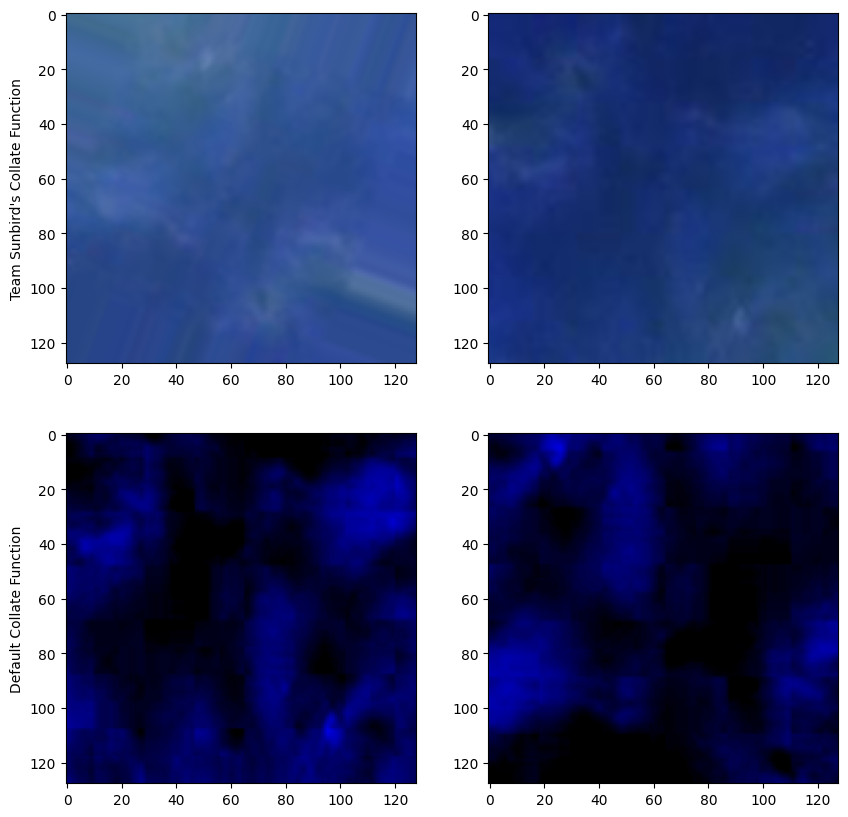

In [21]:
idx = 10
print(dataset_train_simsiam[idx])
(img_t0,img_t1),label,file_name = sun_bird_collate_fn([dataset_train_simsiam[idx]])

plt.figure(figsize = (10,10))

print(label,file_name)
plt.subplot(2,2,1)
plt.imshow(img_t0.permute(2,3,1,0)[:,:,:,0])
plt.ylabel("Team Sunbird's Collate Function")
plt.subplot(2,2,2)
plt.imshow(img_t1.permute(2,3,1,0)[:,:,:,0])

(img_t0,img_t1),label,file_name = collate_fn([dataset_train_simsiam[idx]])

print(label,file_name)
plt.subplot(2,2,3)
plt.imshow(img_t0.permute(2,3,1,0)[:,:,:,0])
plt.ylabel("Default Collate Function")
plt.subplot(2,2,4)
plt.imshow(img_t1.permute(2,3,1,0)[:,:,:,0])

In [22]:
# create a dataloader for training
dataloader_train_simsiam = torch.utils.data.DataLoader(
    dataset_train_simsiam,
    batch_size=batch_size,
    shuffle=True,           # data reshuffled at every epoch if True
    collate_fn=sun_bird_collate_fn,  # constructs function
    drop_last=True,         # If want to merge datasets (optional) - mostly used when batches are loaded from map-styled datasets.
    num_workers=num_workers,
)

# create a dataloader for embedding
dataloader_val = torch.utils.data.DataLoader(
    dataset_val_simsiam,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)


torch.Size([64, 3, 128, 128])


Text(0.5, 1.0, 'print min = 0.10980392247438431, max = 0.5843137502670288')

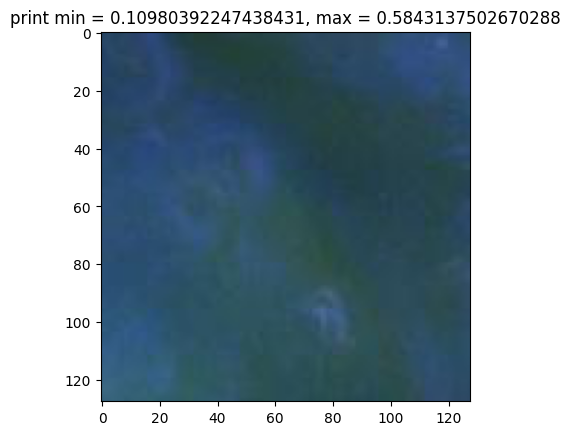

In [23]:
#check normalization of validation images
batch = next(iter(dataloader_val))
print(batch[0].shape)
im = batch[0].permute(2,3,1,0)[:,:,:,0]
plt.imshow(im)
plt.title(f"print min = {im.min()}, max = {im.max()}")

## Training the model

In [24]:
device = "gpu" if torch.cuda.is_available() else "cpu"

trainer = pl.Trainer(max_epochs=epochs, devices=1, accelerator=device, logger=wandb_logger, log_every_n_steps=10, deterministic=True)

wandb_logger.watch(model)
trainer.fit(model=model, train_dataloaders=dataloader_train_simsiam)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type                     | Params
-------------------------------------------------------------
0 | backbone        | Sequential               | 11.2 M
1 | projection_head | SimSiamProjectionHead    | 788 K 
2 | prediction_head | SimSiamPredictionHead    | 131 K 
3 | criterion       | NegativeCosineSimilarity | 0     
-------------------------------------------------------------
12.1 M    Trainable params
0         Non-trainable params
12.1 M    Total

Training: 0it [00:00, ?it/s]

BrokenPipeError: ignored

Error in callback <function _WandbInit._pause_backend at 0x7f10bd55d5a0> (for post_run_cell):


BrokenPipeError: ignored

## Visualizing SDO tile clusters

In [ ]:
# Now that the model is trained, embed images into dataset
embeddings = []
filenames = []

# disable gradients for faster calculations
model.eval()
with torch.no_grad():
    # passes batches and filenames to model to find embeddings
    # embedding -> vectorize image, simpler representation of image
    for i, (x, _, fnames) in enumerate(dataloader_val):
        # move the images to the gpu
        # embed the images with the pre-trained backbone
        y = model.backbone(x).flatten(start_dim=1)
        # store the embeddings and filenames in lists
        embeddings.append(y)
        filenames = filenames + list(fnames)

# concatenate the embeddings and convert to numpy
embeddings = torch.cat(embeddings, dim=0)
embeddings = embeddings.cpu().numpy()

In [ ]:
# transform embeddings to 2D using UMAP (dimension reduction algorithm)

# for the scatter plot we want to transform the images to a two-dimensional
# vector space using projections
gaussian_2d = random_projection.GaussianRandomProjection(n_components=2, random_state=0)
tsne_2d = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne_2d.fit_transform(embeddings)
M = np.max(embeddings_2d, axis=0)
m = np.min(embeddings_2d, axis=0)
embeddings_2d = (embeddings_2d - m) / (M - m)

# gaussian = random_projection.GaussianRandomProjection(n_components=3, random_state=0)
# pca = PCA(n_components=3, random_state=0)
# tsne = TSNE(n_components=3, random_state=0)

# gaussian_embeddings = gaussian.fit_transform(embeddings)
# pca_embeddings = pca.fit_transform(embeddings)
# tsne_embedding = tsne.fit_transform(embeddings)


# # normalize the embeddings to fit in the [0, 1] square
# embed_list = [gaussian_embeddings, pca_embeddings, tsne_embedding]
# for i in range(len(embed_list)):
#     M = np.max(embed_list[i], axis=0)
#     m = np.min(embed_list[i], axis=0)
#     embed_list[i] = (embed_list[i] - m) / (M - m)

# Diverse Sampling of data

In [ ]:
embeddings_2d.shape

(4485, 2)

Stuff 0: 0.4893633830721759 2.671914806148625
Stuff 1: 0.5223510036947142 2.6093249659091335
Stuff 2: 0.19674726444649712 2.5466484020520017


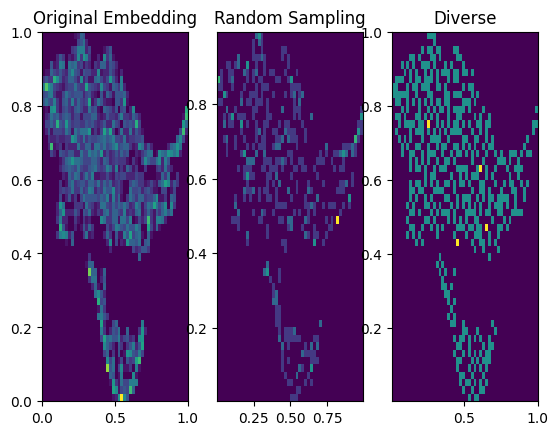

In [ ]:
from search_simsiam.diverse_sampling import diverse_sampler
import plotly.express as px
from scipy import stats

def get_density(x:np.ndarray, y:np.ndarray):
    """Get kernal density estimate for each (x, y, z) point."""
    values = np.vstack([x, y])
    kernel = stats.gaussian_kde(values)
    density = kernel(values)
    return density

points_array = np.array(embeddings_2d)

x = points_array[:, 0]
y = points_array[:, 1]

# plt.subplot(1, 3, 1)
# plt.scatter(x, y)
# plt.title("Original Biased Circles Dataset")
# plt.xlabel("X")
# plt.ylabel("Y")

np.random.shuffle(points_array)
random_subset_points_array = points_array[:500]
x = random_subset_points_array[:, 0]
y = random_subset_points_array[:, 1]


def embedder(x): return x
points_array = np.array(points_array)

r = diverse_sampler(embedder, points_array, 500)
r = np.array(r)
x = r[:, 0]
y = r[:, 1]



title = ['Original Embedding', 'Random Sampling', 'Diverse']
dpts = [points_array, random_subset_points_array, r]
ar = []

for par in dpts:
    df = {}
    df['comp1'] = par[:, 0]
    df['comp2'] = par[:, 1]
    ar.append(df)

# df_pa = {}
# df_pa['comp1'] = points_array[:, 0]
# df_pa['comp2'] = points_array[:, 1]

# df_rs = {}
# df_rs['comp1'] = random_subset_points_array[:, 0]
# df_rs['comp2'] = random_subset_points_array[:, 1]

# df_r = {}
# df_r['comp1'] = r[:, 0]
# df_r['comp2'] = r[:, 1]

# ar = [df_pa, df_rs, df_r]

for i, a in enumerate(ar):
    # d = get_density(a['comp1'], a['comp2'])
    d = get_density(dpts[i][:,0], dpts[i][:,1])
    print(f'Stuff {i}:', d.min(), d.max())

    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    plt.hist2d(dpts[i][:,0], dpts[i][:,1], bins=50)

    # fig = px.scatter(a, x='comp1', y='comp2', color=d, title=title[i])
    # fig.show()
plt.show()

In [ ]:
import plotly.express as px
from scipy import stats


def get_density(x:np.ndarray, y:np.ndarray, z:np.ndarray):
    """Get kernal density estimate for each (x, y, z) point."""
    values = np.vstack([x, y, z])
    kernel = stats.gaussian_kde(values)
    density = kernel(values)
    return density

# df = {}
# df['comp1'] = gaussian_embeddings_2d[:,0]
# df['comp2'] = gaussian_embeddings_2d[:,1]
#fig = px.scatter_3d(df, x='comp1', y='comp2', z='comp3', color_discrete_sequence=['red'])

title = ['Gaussian', 'PCA', 'tSNE']
for i, embed in enumerate(embed_list):
    m1 = embed[:,0]
    m2 = embed[:,1]
    m3 = embed[:,2]
    d = get_density(m1, m2, m3)
    fig = px.scatter_3d(x=m1, y=m2, z=m3, color=d, title=title[i])
    fig.update_traces(marker=dict(size=2))
    fig.show()

    # TODO:
    #   Need to log this into wandb
    # wandb.log({f"Embeddings_2D_{title[i]}" : wandb.Image(fig)})

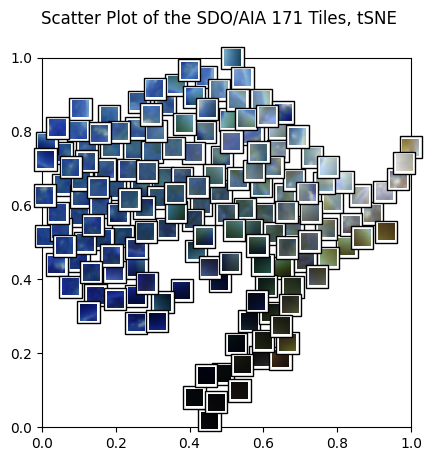

In [ ]:
# display a scatter plot of the dataset
# clustering similar images together

# TODO:
#   Integrate new 3d embedding
#   Find a way to eval optimal clustering (?)

def get_scatter_plot_with_thumbnails():
    """Creates a scatter plot with image overlays."""
    # initialize empty figure and add subplot
    fig = plt.figure()
    fig.suptitle("Scatter Plot of the SDO/AIA 171 Tiles, tSNE")
    ax = fig.add_subplot(1, 1, 1)
    # shuffle images and find out which images to show
    shown_images_idx = []
    shown_images = np.array([[1.0, 1.0]])
    iterator = [i for i in range(embeddings_2d.shape[0])]
    np.random.shuffle(iterator)
    for i in iterator:
        # only show image if it is sufficiently far away from the others
        dist = np.sum((embeddings_2d[i] - shown_images) ** 2, 1)
        if np.min(dist) < 2e-3:
            continue
        shown_images = np.r_[shown_images, [embeddings_2d[i]]]
        shown_images_idx.append(i)

    # plot image overlays
    for idx in shown_images_idx:
        thumbnail_size = int(rcp["figure.figsize"][0] * 2.0)
        path = os.path.join(path_to_data, filenames[idx])
        img = Image.open(path)
        img = functional.resize(img, thumbnail_size)
        img = np.array(img)
        img_box = osb.AnnotationBbox(
            osb.OffsetImage(img, cmap=plt.cm.gray_r),
            embeddings_2d[idx],
            pad=0.2,
        )
        ax.add_artist(img_box)

    # set aspect ratio
    ratio = 1.0 / ax.get_data_ratio()
    ax.set_aspect(ratio, adjustable="box")
    return fig


# get a scatter plot with thumbnail overlays
fig = get_scatter_plot_with_thumbnails()

In [ ]:
wandb.log({"Tile_vs_Embeddings_2D": wandb.Image(fig)})
wandb.finish()

# Nearest neighbour search

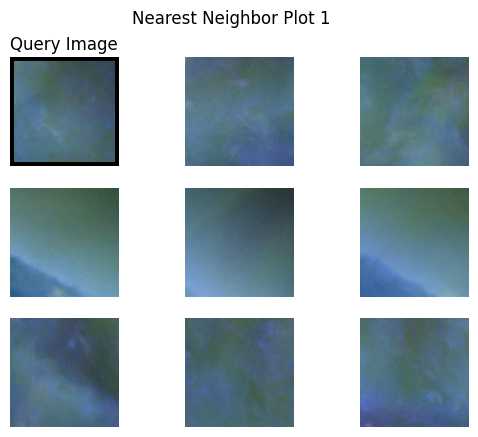

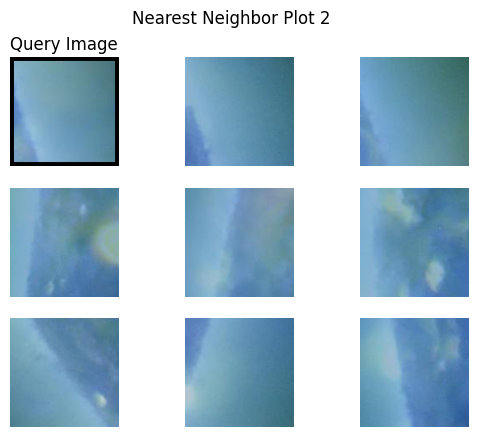

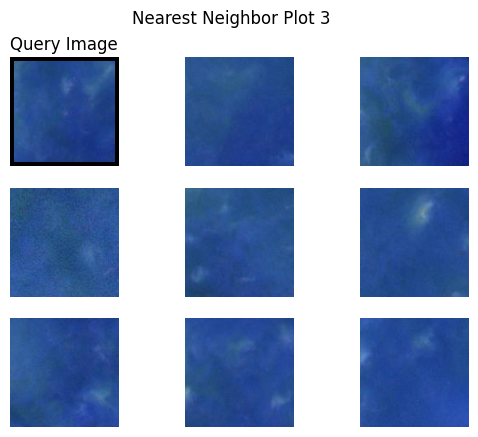

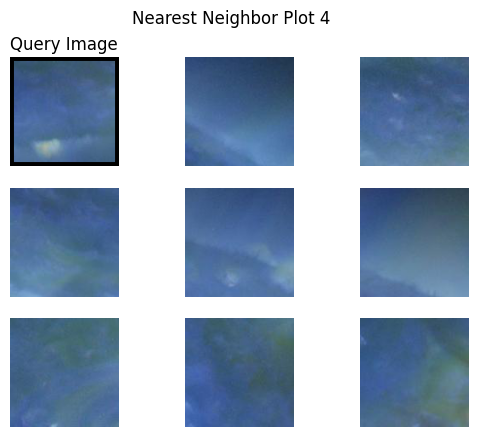

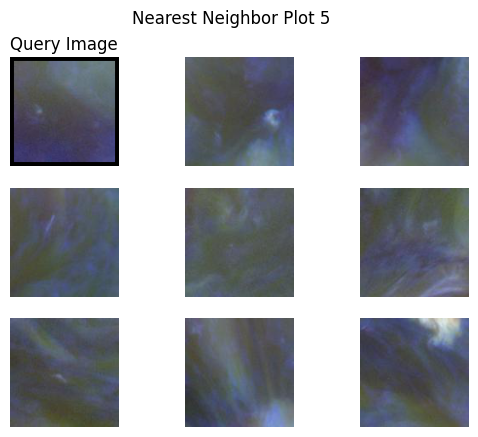

In [ ]:
# takes the 8 closest images to each example image and plot them together

example_images = [filenames[10**n] for n in range(5)]

def get_image_as_np_array(filename: str):
    """Loads the image with filename and returns it as a numpy array."""
    img = Image.open(filename)
    return np.asarray(img)


def get_image_as_np_array_with_frame(filename: str, w: int = 5):
    """Returns an image as a numpy array with a black frame of width w."""
    img = get_image_as_np_array(filename)
    ny, nx, _ = img.shape
    # create an empty image with padding for the frame
    framed_img = np.zeros((w + ny + w, w + nx + w, 3))
    framed_img = framed_img.astype(np.uint8)
    # put the original image in the middle of the new one
    framed_img[w:-w, w:-w] = img
    return framed_img


def plot_nearest_neighbors_3x3(example_image: str, i: int):
    """Plots the example image and its eight nearest neighbors."""
    n_subplots = 9
    # initialize empty figure
    fig = plt.figure()
    fig.suptitle(f"Nearest Neighbor Plot {i + 1}")
    #
    example_idx = filenames.index(example_image)
    # get distances to the cluster center
    distances = embeddings - embeddings[example_idx]
    distances = np.power(distances, 2).sum(-1).squeeze()
    # sort indices by distance to the center
    nearest_neighbors = np.argsort(distances)[:n_subplots]
    # show images
    for plot_offset, plot_idx in enumerate(nearest_neighbors):
        ax = fig.add_subplot(3, 3, plot_offset + 1)
        # get the corresponding filename
        fname = os.path.join(path_to_data, filenames[plot_idx])
        if plot_offset == 0:
            ax.set_title(f"Query Image")
            plt.imshow(get_image_as_np_array_with_frame(fname))
        else:
            plt.imshow(get_image_as_np_array(fname))
        # let's disable the axis
        plt.axis("off")


# show example images for each cluster
for i, example_image in enumerate(example_images):
    plot_nearest_neighbors_3x3(example_image, i)